# LINE-1 IMPLEMENTATION

The original source code from the paper can be found here: [https://github.com/tangjianpku/LINE/tree/master](https://github.com/tangjianpku/LINE/tree/master)

This was also used as help in this implementation.

In [3]:
import random
import time
from tqdm import tqdm
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer, normalize

from sklearn.model_selection import KFold, cross_validate
from sklearn.multiclass import OneVsRestClassifier

import torch
from torch.nn import functional as F

## Creation of a simple test graph

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


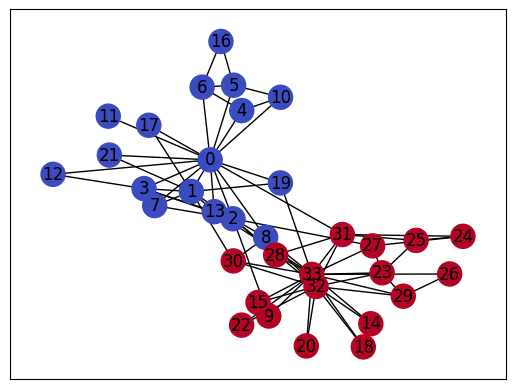

In [4]:
# Creation of a random graph // Upload a graph
G = nx.karate_club_graph()

# Assignment of the labels. Each student belongs to 1 of the 2 possible clubs
clubs = []
print(G.nodes)

for n in G.nodes:
    c = G.nodes[n]['club']  # karate club name, can be either 'Officer' or 'Mr. Hi'
    clubs.append(1 if c == 'Officer' else 0)
    
pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
nx.draw_networkx(G, pos=pos, node_color = clubs, cmap='coolwarm') # Plot the graph

# Helper functions

In [5]:
def generate_alias(probs):
    """
    Generates an Alias table to sample from based on some probability distribution p
    :param probs: distribution to create the Alias table
    :return: A (Alias table)
    """
    l = len(probs)
    L, H = [], []
    
    for i, p in enumerate(probs):
        if p <= 1/l:
            L.append((i, p))
        else:
            H.append((i, p))
    
    A = []
    while len(L) > 0 and len(H) > 0:
        i, p_i = L.pop()
        h, p_h = H.pop()
        
        A.append((i, h, p_i))
        if p_h - p_i > 1/l:
            H.append((h, p_h - p_i))
        else:
            L.append((h, p_h - p_i))

    # Handling any remaining items
    while len(L) > 0:
        i, p = L.pop()
        A.append((i, i, 1/l))
    
    while len(H) > 0:
        h, p = H.pop()
        A.append((h, h, 1/l))
    return A


def sample_alias(A, l):
    """
    Samples an outcome from the alias table over a distribution p
    :param A: Alias table
    :param l: length of the probability distribution
    :return: an index based on the sampling outcome
    """
    draw = np.random.randint(l)
    i, h, p = A[draw]
    if np.random.rand() < l * p:
        return h
    else:
        return i


def init_neg_table(G, size):
    """
    Creates a table for the negative sampling of vertices according to vertex degrees 
    :param G: Graph from which to sample
    :param size: size of the table
    :return: Negative sampling table
    """
    degrees_prob = np.zeros(G.number_of_nodes())
    for node, d in G.degree:
        # P_n(v) ∝ d_v ** 0.75 from the paper
        degrees_prob[node] = d ** 0.75
    
    Z = np.sum(degrees_prob)
    neg_table = np.zeros(int(size), dtype=np.uint32)
    
    neg_table_id = 0
    for i, p in enumerate(degrees_prob):
        portion_to_fill = np.round((p/Z) * size).astype(int)
        neg_table[neg_table_id:neg_table_id+portion_to_fill] = i
        neg_table_id += portion_to_fill
    return neg_table


# Start of the model

In [6]:
neg_table_size = 1e8  # default, same as in the original source code
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

node2int = {node: i for i, node in enumerate(G.nodes())}

edges = [[node2int[u], node2int[v]] for u, v in G.edges()]
edges_prob = np.array([G[u][v]["weight"] for u, v in G.edges()])
edges_prob = edges_prob/np.sum(edges_prob)

neg_table = init_neg_table(G, neg_table_size)
alias_table = generate_alias(edges_prob)
print('Num nodes:', num_nodes, 'Edges:', num_edges)

Num nodes: 34 Edges: 78


In [7]:
# hyperparameters from the paper
dim = 128
alpha = 0.025
neg_samples = 5
T = 1e6

np.random.seed(42)
# starting embedding, uniform [-0.5, 0.5]
init_embeddings = (np.random.random((num_nodes, dim)) - 0.5)/dim

In [8]:
def update(u_i, u_j, alpha, acc_gradient, local_label):
    """
    The update equation for the SGD in the LINE-1 algorithm
    :param u_i: source representation for vertex i
    :param u_j: source representation for vertex j
    :param alpha: learning rate
    :param acc_gradient: accumulated gradient
    :param local_label: label in the local graph (1=connected, 0=not connected)
    :return: 
    """
    f_line = 1/(1 + np.exp(-(u_i @ u_j)))  # sigmoid
    g = (f_line - local_label) * alpha
    
    acc_gradient -=  g * u_j
    u_j -= g * u_i
    return 


def train_line(embeddings, alpha_0, num_samples, edges, alias_table, neg_samples, neg_table):
    """
    Trains a LINE-1 algorithm embeddings via Edge Sampling with a minibatch size of 1
    :param embeddings: vertex embeddings to train
    :param alpha_0: starting learning rate
    :param num_samples: number of edge samples used for training
    :param edges: edges in the graph
    :param alias_table: alias table to sample edges
    :param neg_samples: amount of negative samples
    :param neg_table: table to use for negative samples 
    :return: trained embeddings
    """
    trained_embeddings = embeddings.copy()
    
    start = time.time()
    alpha = alpha_0
    
    for i in tqdm(range(int(num_samples))):
        if i > 0:
            alpha = alpha_0*(1-i/num_samples)
        
        edge = sample_alias(alias_table, num_edges)
        u, v = edges[edge]
        
        acc_gradient = np.zeros(dim)
        update(trained_embeddings[u], trained_embeddings[v], alpha, acc_gradient, local_label=1)
        
        for k in range(neg_samples):
            v = random.choice(neg_table)
            update(trained_embeddings[u], trained_embeddings[v], alpha, acc_gradient, local_label=0)
        
        trained_embeddings[u] += acc_gradient
    print(f"Training time: {time.time() - start}s")
    return trained_embeddings

In [9]:
init_embeddings

array([[-9.80155322e-04,  3.52120552e-03,  1.81245267e-03, ...,
        -5.69470401e-04,  2.48449036e-03,  2.81820768e-03],
       [-3.85193648e-03,  8.39633014e-05, -6.45226538e-04, ...,
        -1.43029683e-03, -2.58208792e-03,  4.43759863e-04],
       [ 3.40745917e-03,  1.53148279e-03,  5.47352891e-04, ...,
         1.53700910e-03,  1.00736599e-03,  2.94900011e-03],
       ...,
       [ 6.90251726e-04, -7.99340512e-04,  3.70156573e-03, ...,
         3.35046523e-03, -1.31272262e-03, -2.70805204e-04],
       [-3.79935613e-03, -3.26876000e-03, -1.88600319e-03, ...,
         8.87796117e-04,  3.10886948e-03,  2.42128453e-03],
       [ 6.49454837e-04,  1.79860717e-03, -1.05607445e-03, ...,
         1.02702182e-03,  2.22191776e-03,  7.70023385e-04]])

In [10]:
embeddings = train_line(init_embeddings, alpha, T, edges, alias_table, neg_samples, neg_table)
embeddings

100%|██████████| 1000000/1000000 [00:24<00:00, 41340.41it/s]

Training time: 24.207793951034546s


array([[ 0.03199843,  0.07233451,  0.05468631, ..., -0.04598937,
        -0.0554153 , -0.01398735],
       [ 0.02146771, -0.00479935,  0.0752014 , ..., -0.04772551,
        -0.15185415,  0.00857699],
       [ 0.08100939,  0.0364984 ,  0.04538271, ...,  0.01650832,
        -0.05222575,  0.06972751],
       ...,
       [-0.08503929, -0.09019353, -0.02863622, ...,  0.13012114,
         0.0475711 , -0.02843058],
       [-0.09766013, -0.07812748, -0.13990664, ..., -0.10768237,
         0.18433302, -0.07836926],
       [ 0.98407017, -0.91153434, -0.8772773 , ...,  1.63973998,
        -0.58189242,  0.97706893]])

In [11]:
norm_embed = normalize(embeddings)
norm_embed

array([[ 0.04764521,  0.10770505,  0.08142714, ..., -0.06847752,
        -0.08251259, -0.02082697],
       [ 0.02753016, -0.00615469,  0.09643818, ..., -0.06120313,
        -0.19473758,  0.01099912],
       [ 0.10443947,  0.04705471,  0.0585086 , ...,  0.02128297,
        -0.06733082,  0.08989457],
       ...,
       [-0.08611994, -0.09133969, -0.02900012, ...,  0.13177468,
         0.04817562, -0.02879186],
       [-0.07568662, -0.06054881, -0.10842767, ..., -0.08345385,
         0.14285812, -0.06073619],
       [ 0.08601774, -0.07967737, -0.07668296, ...,  0.14332995,
        -0.05086332,  0.08540576]])

In [12]:
def find_classes(g_labels):
    """Finds the class folder names in a Graph.
    Example: find_classes("datasets/train") returns (["class_1", "class_2"], {"class_1": 0, ...})
    Args:
        directory (str): target directory to load classnames from.
    Returns:
        tuple: (list_of_class_names, dict(class_name: idx...))
    """
    # Get the class names by scanning the target directory
    classes = set(g_labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    labels = np.array([class_to_idx[label] for label in classes])
    return labels


def get_array_labels(G):
  '''
  Input:
    G: Graph
  Output:
    labels: Array with labels. Each position of the array will correspond to the groups of id = index + 1
  '''
  labels = []

  for n in G.nodes:
      l = G.nodes[n].get('club')
      labels.append(l)
  return labels

In [13]:
def node_classification(X, y, n_folds=5):
    model = LogisticRegression(multi_class='ovr')
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    eval_scores = {'acc': 'accuracy', 'f1_macro': 'f1_macro', 'f1_micro': 'f1_micro'}
    results = cross_validate(model, X, y, cv=kf, scoring=eval_scores)
    acc, f1_macro, f1_micro = results['test_acc'].mean(), results['test_f1_macro'].mean(), results['test_f1_micro'].mean()
    return acc, f1_macro, f1_micro

In [17]:
labels = get_array_labels(G)
ls = np.zeros(num_nodes)
for i, label in enumerate(labels):
    if label == 'Mr. Hi':
        ls[i] = 0
    else:
        ls[i] = 1

In [19]:
ls

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [14]:
from sklearn.metrics import accuracy_score
# SILVIA'S METHOD
def multi_label_classification(X, y, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    micro_f1_scores = []
    macro_f1_scores = []
    accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        print("y_train shape:", y_train.shape)
        print("X_train shape:", X_train.shape)

        # One-vs-Rest Logistic Regression
        model = LogisticRegression(multi_class='ovr')
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        
        

        # Micro-F1 Score
        micro_f1 = f1_score(y_test, y_pred, average='micro')
        micro_f1_scores.append(micro_f1)

        # Macro-F1 Score
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        macro_f1_scores.append(macro_f1)

    # Calculate mean scores over all folds
    mean_micro_f1 = np.mean(micro_f1_scores)
    mean_macro_f1 = np.mean(macro_f1_scores)
    mean_acc = np.mean(accuracies)

    return mean_acc, mean_micro_f1, mean_macro_f1

In [20]:
ls

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [15]:
# my method
node_classification(norm_embed, ls)

(0.9142857142857143, 0.9105555555555556, 0.9142857142857143)

In [16]:
# SILVIA'S
multi_label_classification(norm_embed, ls)

y_train shape: (27,)
X_train shape: (27, 128)
y_train shape: (27,)
X_train shape: (27, 128)
y_train shape: (27,)
X_train shape: (27, 128)
y_train shape: (27,)
X_train shape: (27, 128)
y_train shape: (28,)
X_train shape: (28, 128)


(0.9095238095238095, 0.9095238095238095, 0.8921789321789321)